# Studying Wikipedia Page Protections
This notebook provides a tutorial for how to study [page protections](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy) on Wikipedia either via the [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Page_restrictions_table) or [API](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo). It has three stages:
* Accessing the Page Protection dumps
* Accessing the Page Protection API
* Example analysis of page protection data (both descriptive statistics and learning a predictive model)

## Accessing the Page Protection Dumps
This is an example of how to parse through [Mediawiki dumps](https://www.mediawiki.org/wiki/Manual:Page_restrictions_table) and determine [what sorts of edit protections](https://en.wikipedia.org/wiki/Wikipedia:Protection_policy#Overview_of_types_of_protection) are applied to a given Wikipedia article.

In [1]:
#import libraries necessary for decompressing the dumpfile to text file
import gzip 
import pandas as pd
import os
import sys
import json
import sqlite3

In [2]:
# Every language on Wikipedia has its own page restrictions table
# In this example we going to study the Swahili Wikipedia
LANGUAGE = 'swwiki'

# swwiki -> sw.wikipedia (this will be necessary for the API section)
SITENAME = LANGUAGE.replace('swwiki', 'sw.wikipedia')

# directory on PAWS server that holds Wikimedia dumps
DUMP_DIR = "/public/dumps/public/{0}/latest/".format(LANGUAGE)
DUMP_FN = '{0}-latest-page_restrictions.sql.gz'.format(LANGUAGE)

In [3]:
# The dataset isn't huge -- 1.1 MB -- so should be quick to process in full
!ls -shH "{DUMP_DIR}{DUMP_FN}"

12K /public/dumps/public/swwiki/latest/swwiki-latest-page_restrictions.sql.gz


In [4]:
# Inspect the first 1000 characters of the page protections dump to see what it looks like
# As you can see from the CREATE TABLE statement, each datapoint has 7 fields (pr_page, pr_type, ... , pr_id)
# A description of the fields in the data can be found here:
#   https://www.mediawiki.org/wiki/Manual:Page_restrictions_table
# And the data that we want is on lines that start with INSERT INTO `page_restrictions` VALUES...
# The first datapoint (1086732,'edit','sysop',0,NULL,'infinity',1307) can be interpreted as:
#   1086732:    page ID 1086732 (en.wikipedia.org/wiki/?curid=1086732)
#   'edit':     has edit protections
#   'sysop':    that require sysop permissions (https://en.wikipedia.org/wiki/Wikipedia:User_access_levels#Administrator)
#   0:          does not cascade to other pages
#   NULL:       no user-specific restrictions
#   'infinity': restriction does not expire automatically
#   1307:       table primary key -- has no meaning by itself

!zcat "{DUMP_DIR}{DUMP_FN}" | head -46 | cut -c1-1000

-- MySQL dump 10.16  Distrib 10.1.45-MariaDB, for debian-linux-gnu (x86_64)
--
-- Host: 10.64.32.136    Database: swwiki
-- ------------------------------------------------------
-- Server version	10.4.12-MariaDB-log

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!40101 SET NAMES utf8mb4 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;

--
-- Table structure for table `page_restrictions`
--

DROP TABLE IF EXISTS `page_restrictions`;
/*!40101 SET @saved_cs_client     = @@character_set_client */;
/*!40101 SET character_

In [5]:
#decompress the dump file
!zcat {DUMP_DIR}{DUMP_FN} -cfv -l

method  crc     date  time           compressed        uncompressed  ratio uncompressed_name
defla b4da5be7 Oct 20 11:44                9272               74798  87.6% /public/dumps/public/swwiki/latest/swwiki-latest-page_restrictions.sql


In [6]:
#select the data we want and convert it to a text file
!zcat {DUMP_DIR}{DUMP_FN} | grep  INSERT > output.txt

In [7]:
#clean file by removing parenthesis around our data  
! cat output.txt | tr -d '(' | tr ')' '\n' > page_restrictions.txt

In [8]:
#remove any extra unwanted characters from out dataset
! sed -i.bak 's/,//' page_restrictions.txt

In [9]:
#convert .txt to csv for later use and easy format
df = pd.read_csv("page_restrictions.txt",header=None)
df.columns = ['pr_id','pr_type','pr_level','pr_cascade','pr_user','pr_expiry','pr_page']
df.to_csv('page_restrictions.csv',index=None)

df.head(5)

,pr_id,pr_type,pr_level,pr_cascade,pr_user,pr_expiry,pr_page
0,13506,'edit','autoconfirmed',0,NaN,'infinity',13
1,13506,'move','autoconfirmed',0,NaN,'infinity',14
2,3049,'edit','autoconfirmed',0,NaN,'infinity',15
3,3049,'move','autoconfirmed',0,NaN,'infinity',16
4,3053,'edit','autoconfirmed',0,NaN,'infinity',17


In [10]:
#loop through all page restrictions
df = pd.read_csv('page_restrictions.csv')
for ind in df.index: 
     print(df['pr_id'][ind], df['pr_type'][ind],df['pr_level'][ind],df['pr_cascade'][ind],df['pr_user'][ind],
           df['pr_expiry'][ind],df['pr_page'][ind]) 
print("\nIterating over rows using index attribute :\n") 

13506 'edit' 'autoconfirmed' 0 nan 'infinity' 13
13506 'move' 'autoconfirmed' 0 nan 'infinity' 14
3049 'edit' 'autoconfirmed' 0 nan 'infinity' 15
3049 'move' 'autoconfirmed' 0 nan 'infinity' 16
3053 'edit' 'autoconfirmed' 0 nan 'infinity' 17
3053 'move' 'autoconfirmed' 0 nan 'infinity' 18
13523 'edit' 'autoconfirmed' 0 nan 'infinity' 19
13523 'move' 'autoconfirmed' 0 nan 'infinity' 20
13555 'edit' 'autoconfirmed' 0 nan 'infinity' 21
13555 'move' 'autoconfirmed' 0 nan 'infinity' 22
13908 'edit' 'sysop' 1 nan 'infinity' 27
13908 'move' 'sysop' 1 nan 'infinity' 28
14032 'edit' 'sysop' 0 nan 'infinity' 31
14032 'move' 'sysop' 0 nan 'infinity' 32
15192 'edit' 'autoconfirmed' 0 nan 'infinity' 37
15192 'move' 'autoconfirmed' 0 nan 'infinity' 38
13888 'edit' 'autoconfirmed' 0 nan 'infinity' 39
13888 'move' 'autoconfirmed' 0 nan 'infinity' 40
2121 'edit' 'autoconfirmed' 0 nan 'infinity' 41
2121 'move' 'autoconfirmed' 0 nan 'infinity' 42
16664 'edit' 'sysop' 0 nan 'infinity' 45
16664 'move' 'sys

## Accessing the Page Protection APIs
The [Page Protection API](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Binfo) can be a much simpler way to access data about page protections for a given article if you know what articles you are interested in and are interested in relatively few articles (e.g., hundreds or low thousands).

NOTE: the APIs are up-to-date while the Mediawiki dumps are always at least several days behind -- i.e. for specific snapshots in time -- so the data you get from the Mediawiki dumps might be different from the APIs if permissions have changed to a page's protections in the intervening days.

In [11]:
# libraries necessary for accessing Wikimedia API
import mwapi
import requests

In [12]:
##Gather ten random page IDs from the data gathered from the Mediawiki dump to get data for from the API
session = mwapi.Session("https://sw.wikipedia.org/w/api.php")

rnd_data = session.get(action = 'query',pageids = '13546|3049|3053|13523|13555|13908|14032|15192|13888|2121', prop='info',
                       inprop='protection',format='json')
print(rnd_data)

Sending requests with default User-Agent.  Set 'user_agent' on mwapi.Session to quiet this message.


{'batchcomplete': '', 'query': {'pages': {'2121': {'pageid': 2121, 'ns': 0, 'title': 'Adolf Hitler', 'contentmodel': 'wikitext', 'pagelanguage': 'sw', 'pagelanguagehtmlcode': 'sw', 'pagelanguagedir': 'ltr', 'touched': '2020-10-12T16:06:54Z', 'lastrevid': 1066099, 'length': 59675, 'protection': [{'type': 'edit', 'level': 'autoconfirmed', 'expiry': 'infinity'}, {'type': 'move', 'level': 'autoconfirmed', 'expiry': 'infinity'}], 'restrictiontypes': ['edit', 'move']}, '3049': {'pageid': 3049, 'ns': 10, 'title': 'Kigezo:Uainishaji', 'contentmodel': 'wikitext', 'pagelanguage': 'sw', 'pagelanguagehtmlcode': 'sw', 'pagelanguagedir': 'ltr', 'touched': '2017-11-07T19:39:34Z', 'lastrevid': 1018000, 'length': 6616, 'protection': [{'type': 'edit', 'level': 'autoconfirmed', 'expiry': 'infinity'}, {'type': 'move', 'level': 'autoconfirmed', 'expiry': 'infinity'}], 'restrictiontypes': ['edit', 'move']}, '3053': {'pageid': 3053, 'ns': 10, 'title': 'Kigezo:Mto', 'contentmodel': 'wikitext', 'pagelanguage':


After gathering ten random pages from the dump data and got the same response from the api,now lets create a loop and compare the data from both the dump and api and see if there would be any differences between the two

In [13]:


""" 130614 page is a move as we can see below it returned as a differnce.Although the data is the same but due to 
the fact that the dump data takes a few days to be updated unlike the API.This is why we have a difference below. 
"""

dump_data = (df['pr_id'][ind], df['pr_type'][ind],df['pr_level'][ind],df['pr_cascade'][ind],
           df['pr_expiry'][ind],df['pr_page'][ind]) 
api_data = rnd_data

set_diff = set(dump_data) - set(api_data) 
list_diff = list(set_diff)

print(list_diff)

[0, "'infinity'", "'move'", 1864, "'autoconfirmed'", 130614]


## Example Analyses of Page Protection Data
Here we show some examples of things we can do with the data that we gathered about the protections for various Wikipedia articles. 
* The [page table](https://www.mediawiki.org/wiki/Manual:Page_table), which, for example, can be found in the `DUMP_DIR` under the name `{LANGUAGE}-latest-page.sql.gz`


In [14]:
#import libraries for data analysis / visualization 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data = pd.read_csv("page_restrictions.csv")
data.head()

,pr_id,pr_type,pr_level,pr_cascade,pr_user,pr_expiry,pr_page
0,13506,'edit','autoconfirmed',0,NaN,'infinity',13
1,13506,'move','autoconfirmed',0,NaN,'infinity',14
2,3049,'edit','autoconfirmed',0,NaN,'infinity',15
3,3049,'move','autoconfirmed',0,NaN,'infinity',16
4,3053,'edit','autoconfirmed',0,NaN,'infinity',17


In [16]:
#clean the data and remove characters contained in the data 

pr_type = data.pr_type.str.split("'",expand=True)
pr_type = data.pr_type.str.split("'",expand=True)

pr_level = data.pr_level.str.split("'",expand=True)
pr_level = data.pr_level.str.split("'",expand=True)

pr_expiry = data.pr_expiry.str.split("'",expand=True)
pr_expiry = data.pr_expiry.str.split("'",expand=True)


In [17]:
pr_type.head(2)

,0,1,2
0,,edit,
1,,move,


In [18]:
data['pr_type'] = pr_type.loc[:,1]
data['pr_level'] = pr_level.loc[:,1]
data['pr_expiry'] = pr_expiry.loc[:,1]

In [19]:
data.to_csv('Page_Restrictions.csv')

In [20]:
data.head(10)

,pr_id,pr_type,pr_level,pr_cascade,pr_user,pr_expiry,pr_page
0,13506,edit,autoconfirmed,0,NaN,infinity,13
1,13506,move,autoconfirmed,0,NaN,infinity,14
2,3049,edit,autoconfirmed,0,NaN,infinity,15
3,3049,move,autoconfirmed,0,NaN,infinity,16
4,3053,edit,autoconfirmed,0,NaN,infinity,17
5,3053,move,autoconfirmed,0,NaN,infinity,18
6,13523,edit,autoconfirmed,0,NaN,infinity,19
7,13523,move,autoconfirmed,0,NaN,infinity,20
8,13555,edit,autoconfirmed,0,NaN,infinity,21
9,13555,move,autoconfirmed,0,NaN,infinity,22


In [21]:
df = data.copy()

In [22]:
#describe dataset
df.describe()

,pr_id,pr_cascade,pr_user,pr_page
count,1374.000000,1374.000000,0.0,1374.000000
mean,50024.131732,0.002183,NaN,1115.350801
std,40096.128039,0.046693,NaN,469.571025
min,17.000000,0.000000,NaN,13.000000
25%,13253.000000,0.000000,NaN,734.250000
50%,40071.000000,0.000000,NaN,1153.500000
75%,91529.000000,0.000000,NaN,1516.750000
max,130614.000000,1.000000,NaN,1864.000000


In [23]:
#check dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pr_id       1374 non-null   int64  
 1   pr_type     1374 non-null   object 
 2   pr_level    1374 non-null   object 
 3   pr_cascade  1374 non-null   int64  
 4   pr_user     0 non-null      float64
 5   pr_expiry   1374 non-null   object 
 6   pr_page     1374 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 75.3+ KB


In [24]:
#check nul values
df.isnull().sum()

pr_id            0
pr_type          0
pr_level         0
pr_cascade       0
pr_user       1374
pr_expiry        0
pr_page          0
dtype: int64

In [25]:
#drop pr_user column as its no use to us
df.drop(['pr_user'],axis=1,inplace=True)

In [26]:
#check the last 5 rows
df.tail()

,pr_id,pr_type,pr_level,pr_cascade,pr_expiry,pr_page
1369,130478,move,autoconfirmed,0,infinity,1860
1370,130506,edit,autoconfirmed,0,infinity,1861
1371,130506,move,autoconfirmed,0,infinity,1862
1372,130614,edit,autoconfirmed,0,infinity,1863
1373,130614,move,autoconfirmed,0,infinity,1864


In [27]:
df.dtypes

pr_id          int64
pr_type       object
pr_level      object
pr_cascade     int64
pr_expiry     object
pr_page        int64
dtype: object

In [28]:
df.value_counts()

pr_id   pr_type  pr_level       pr_cascade  pr_expiry  pr_page
130614  move     autoconfirmed  0           infinity   1864       1
16497   edit     autoconfirmed  0           infinity   1633       1
16282   move     autoconfirmed  0           infinity   595        1
16351   edit     autoconfirmed  0           infinity   1248       1
16412   edit     autoconfirmed  0           infinity   862        1
                                                                 ..
78569   move     autoconfirmed  0           infinity   1854       1
78700   edit     autoconfirmed  0           infinity   1280       1
        move     autoconfirmed  0           infinity   1281       1
78798   edit     autoconfirmed  0           infinity   1142       1
17      edit     autoconfirmed  0           infinity   712        1
Length: 1374, dtype: int64

 #### The next few cells will check for the unique values count in each of the variables

In [29]:
for k in df.keys():
    print(df[k].value_counts())

70562    3
71477    3
32909    3
32561    3
47805    2
        ..
19416    1
10353    1
74370    1
56625    1
2592     1
Name: pr_id, Length: 704, dtype: int64
edit      704
move      666
upload      4
Name: pr_type, dtype: int64
autoconfirmed    1256
sysop             118
Name: pr_level, dtype: int64
0    1371
1       3
Name: pr_cascade, dtype: int64
infinity    1374
Name: pr_expiry, dtype: int64
1864    1
869     1
861     1
862     1
863     1
       ..
1404    1
1405    1
1406    1
1407    1
13      1
Name: pr_page, Length: 1374, dtype: int64



We can observe that the pr_id does not contain unique ids, which means there could be patterns between the ids, and the issued page protection type.

Also, another observation is that in the pr_type, the upload class contains only 4 samples, whereas there are 2 major classes.  However knowing that upload and move could both mean the same thing that they do not require edition, we going to replace upload with move.

In [30]:
df['pr_type'] = df['pr_type'].replace('upload','move')
df['pr_type'].value_counts()

edit    704
move    670
Name: pr_type, dtype: int64


### Descriptive statistics


In [31]:
# import libraries we going to use
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
#convert strings to values
le = LabelEncoder()

In [33]:
df['pr_type'] = le.fit_transform(df['pr_type'])
df['pr_level'] = le.fit_transform(df['pr_level'])
df['pr_id'] = le.fit_transform(df['pr_id'])
df['pr_page'] = le.fit_transform(df['pr_page'])

In [34]:
df.corr()['pr_type']

pr_id         0.015206
pr_type       1.000000
pr_level      0.007587
pr_cascade   -0.014440
pr_page       0.006167
Name: pr_type, dtype: float64



The above cell shows that the dependent variable (pr_type) is actaully not depending on any of the features. Therefore, there is need to develop the correlation between X columns and y column.

We'll use Logisitic Regression to convert the binary encoded values (0 and 1) to continuous values, for pr_type and pr_level to check if there will be improvements on the overall correlations. This approach will be shown in the next few cells.

In [37]:
X = df[['pr_type','pr_id']]

y = df['pr_level'] 

lr = LogisticRegression()
lr.fit(X, y)


LogisticRegression()

In [36]:
#convert binary values to categorical for the pr_type
type_ = lr.predict_proba(X)

In [38]:
#convert binary values to categorical for the pr_level
level_ = lr.predict_proba(X) 

In [39]:
# Replace the binary encodings with the new continuous values generated by the logistic regression
df['pr_type'] = type_
df['pr_level'] = level_

In [40]:
# We can see they are continuous now
df['pr_level']

0       0.902256
1       0.896881
2       0.891815
3       0.885939
4       0.891930
          ...   
1369    0.941119
1370    0.944394
1371    0.941185
1372    0.944456
1373    0.941251
Name: pr_level, Length: 1374, dtype: float64

In [41]:
# Checking for the correlation
df.corr()['pr_type']

pr_id        -0.997716
pr_type       1.000000
pr_level     -0.985150
pr_cascade    0.014801
pr_page      -0.425124
Name: pr_type, dtype: float64


The above cell shows that the dependent(pr_type) variable correlates better now with some of the independent variables.


In [42]:
pip install statsmodels

You should consider upgrading via the '/srv/paws/bin/python3.6 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [43]:
# import the modules
import statsmodels.api as sm

# single out the input variables X 
X = df['pr_level']

# Add a constant so that it will be 2x2
X= sm.add_constant(X)

# define the target variable y
y = df['pr_type']

# Define the model
model = sm.OLS(y, X)

# Fit the model to the data
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                pr_type   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 4.517e+04
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:32:15   Log-Likelihood:                 7150.9
No. Observations:                1374   AIC:                        -1.430e+04
Df Residuals:                    1372   BIC:                        -1.429e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8788      0.002    509.742      0.0


The R squared value shows there is a postive relationship between the dependent and independent variables. 
The p-value is 0.025, which is less than 0.05 showing that it is statistically significant.

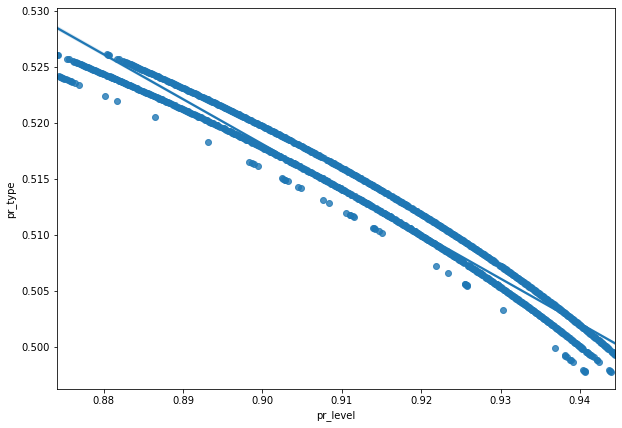

In [44]:
fig,ax = plt.subplots(figsize=(10,7))
ax = sns.regplot(x='pr_level', y='pr_type',data=df)


From the regression plot above, we can see that the Logistic Regression classified 0 around 0.5, and 1 around 0.8, for the pr_level and the pr_type.

The data can now be used to develop a model. However, knowing that our goal is to predict properly the protection type of a Wikipedia article, whether it is moved or edited, we won't be working with the continous pr_type we did above, rather the binary one labelled 0 and 1.

### Predictive Model


In [45]:
#import necessary libraries for our model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [46]:
# We will be using the original target variable to predict and not the continuous
data['pr_type'] = data['pr_type'].replace('upload','move')
data['pr_type'].value_counts()

edit    704
move    670
Name: pr_type, dtype: int64

In [47]:
X = df[['pr_level','pr_page','pr_id']]
y = data['pr_type']

#split data to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [48]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (1099, 3)
X_test: (275, 3)
y_train: (1099,)
y_test: (275,)


In [49]:
X_train.head()

,pr_level,pr_page,pr_id
1226,0.943258,1226,684
1085,0.937799,1085,602
148,0.901416,148,232
1178,0.943066,1178,681
478,0.896771,478,189


In [50]:
assert len(X_train) == len(y_train)

In [51]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [52]:
pred = clf.predict(X_test)
pred

array(['edit', 'edit', 'move', 'edit', 'move', 'edit', 'edit', 'edit',
       'move', 'move', 'move', 'edit', 'move', 'edit', 'edit', 'edit',
       'move', 'edit', 'edit', 'move', 'edit', 'move', 'edit', 'edit',
       'edit', 'edit', 'move', 'move', 'edit', 'move', 'move', 'move',
       'edit', 'move', 'edit', 'edit', 'edit', 'edit', 'move', 'move',
       'edit', 'edit', 'move', 'edit', 'move', 'edit', 'edit', 'move',
       'edit', 'move', 'move', 'edit', 'move', 'move', 'edit', 'move',
       'move', 'edit', 'edit', 'move', 'move', 'edit', 'edit', 'edit',
       'move', 'edit', 'edit', 'move', 'move', 'move', 'edit', 'edit',
       'edit', 'edit', 'move', 'move', 'edit', 'move', 'edit', 'edit',
       'move', 'edit', 'edit', 'edit', 'edit', 'move', 'edit', 'edit',
       'move', 'edit', 'edit', 'move', 'move', 'move', 'edit', 'move',
       'move', 'edit', 'edit', 'move', 'move', 'move', 'move', 'edit',
       'move', 'move', 'edit', 'edit', 'edit', 'edit', 'move', 'edit',
      

In [53]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        edit       0.93      0.94      0.93       135
        move       0.94      0.93      0.94       140

    accuracy                           0.93       275
   macro avg       0.93      0.93      0.93       275
weighted avg       0.93      0.93      0.93       275



In [54]:
print(clf.score(X_test,y_test)*100,'%')

93.45454545454545 %


### Future Analyses
TODO: Describe any additional analyses you can think of that would be interesting (and why) -- even if you are not sure how to do them.


An additional analysis that can be used is the Clustering analysis. A clustering analysis uses an unsupervised technique to make predictions by finding existing patterns in a dataset.For this problem we have a data with very few number of columns, which are not closely related to the dependent variable due to that, working with a supervised model was used because the correlation had to be enhanced by using the Logistic Regression model to produce continous values.




